In [215]:
import pandas as pd
from datetime import datetime

In [216]:
directory='/home/tanmay/coding/minor testing/dataset/SeriesReport-Not Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv'
df=pd.read_csv(directory, parse_dates=['Period'],dayfirst=True)
df.columns=["Months","Sales"]

In [217]:
#removing irrelvant rows
df = df.dropna()

#changing dateTime format
df['Months']=pd.to_datetime(df['Months'])



In [221]:
df.set_index("Months", inplace=True)
df

,Sales
Months,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0
...,...
2019-08-01,545247.0
2019-09-01,496074.0
2019-10-01,525539.0


<AxesSubplot: xlabel='Months'>

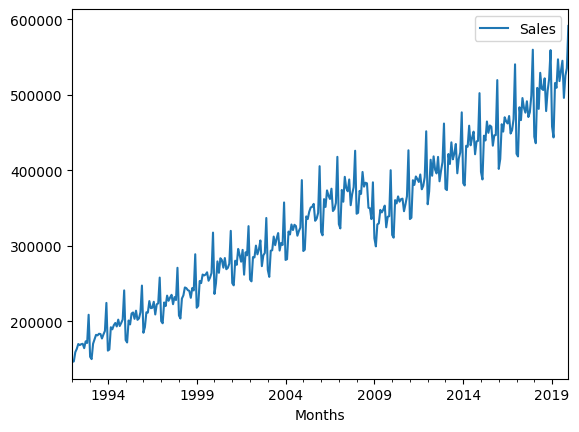

In [222]:
df.plot()

In [223]:
from statsmodels.tsa.stattools import adfuller

In [224]:
res=adfuller(df['Sales'])
res
#if p-value(2nd row of outpt)<=0.05 then stationary else not-stationary

(0.22407261718874094,
 0.9735798907260885,
 15,
 320,
 {'1%': -3.450951662384033,
  '5%': -2.8706147570800784,
  '10%': -2.571604931640625},
 6559.334418816559)

So how to make it stationary:

1. Differecing

In [225]:
#but as seen from the plot the data is seasonal, so instead of shifting it just once will we shift it by one year
#that is 12 months threfore:
df['Seasonal diff']=df['Sales']-df['Sales'].shift(12)

In [226]:
#so now again running the stationary test on the seasonal differenced data
res=adfuller(df['Seasonal diff'].dropna()) #dropna is used to exclude the rows with NaN values
res
#so here the p-val=2.0605796968136632e-11 which is <0.05 therefore its stationary

(-3.109201617813846,
 0.025879679432573643,
 16,
 307,
 {'1%': -3.4518314994261337,
  '5%': -2.8710009653519166,
  '10%': -2.571810878948318},
 6267.748985068207)

<AxesSubplot: xlabel='Months'>

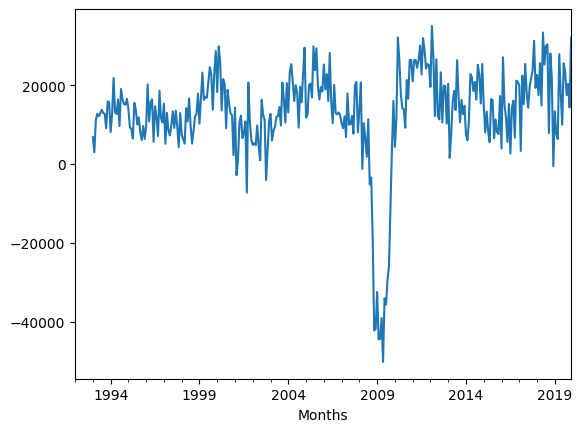

In [227]:
df['Seasonal diff'].plot()
#this also looks stationary

Now we will do auto correlation: it is used to determine that how much lag we will have to use to do the predictoins successfully
ie. how much prev data will be required to make successful predictions

in ARIMA model there are 3 values:
1.  p:AR model lags
2.  d: differencing
3.  q: MA model lags 

I in ARIMA stands for differencing, so if we don't difference the model then its simply ARMA model
AR is often done best with PACF(partial auto correlation function)

In [228]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

Now to know how many lags should we consider, we use pacf:
1. the below graph has pacf as y axis and lags as x axis

/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


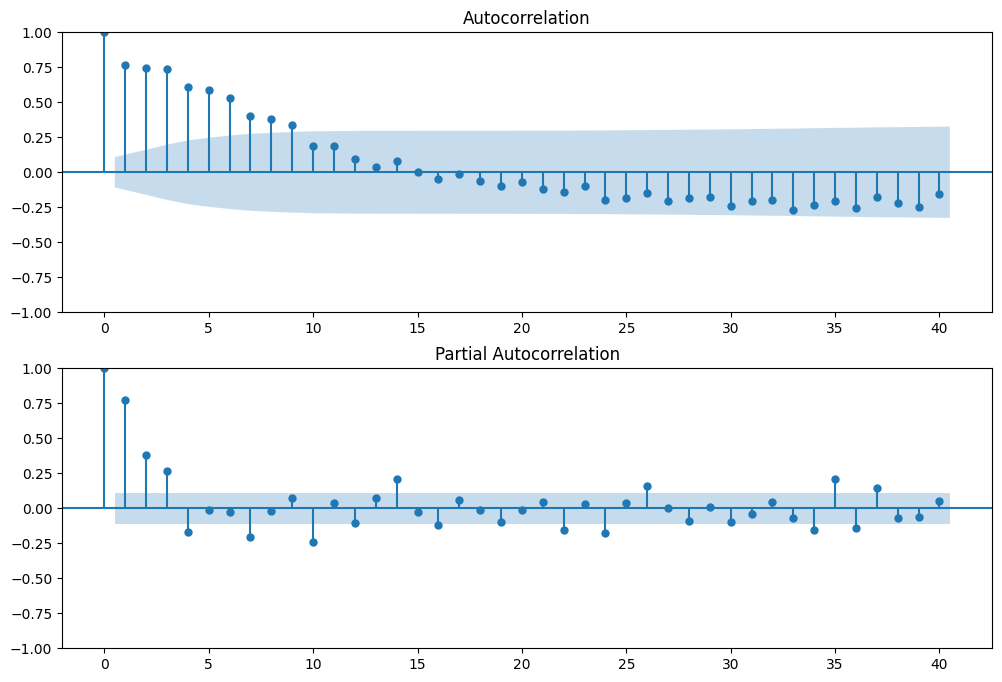

In [229]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_acf(df['Seasonal diff'].dropna(),lags=40,ax=ax1)
fig=sm.graphics.tsa.plot_pacf(df['Seasonal diff'].dropna(),lags=40,ax=ax2)

the blue area is the significance line, so the lags above the sgnificance lines tells the value of p or q depending on the graph:
1. the pacf graph will tell p value (here its 1)
1. the acf graph will tell q value (here its 1 or we can take 0 also)

In [230]:
from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.tsa.arima.model


In [231]:
model = ARIMA(df['Sales'], order=(1,1,1)) #p d,q
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  336
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3888.260
Date:                Mon, 28 Nov 2022   AIC                           7782.519
Time:                        01:50:22   BIC                           7793.962
Sample:                    01-01-1992   HQIC                          7787.081
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0043      0.060      0.071      0.943      -0.113       0.121
ma.L1         -0.7967      0.044    -18.109      0.000      -0.883      -0.710
sigma2      7.275e+08    1.5e-12   4.86e+20      0.0

/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:

model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()


<AxesSubplot: xlabel='Months'>

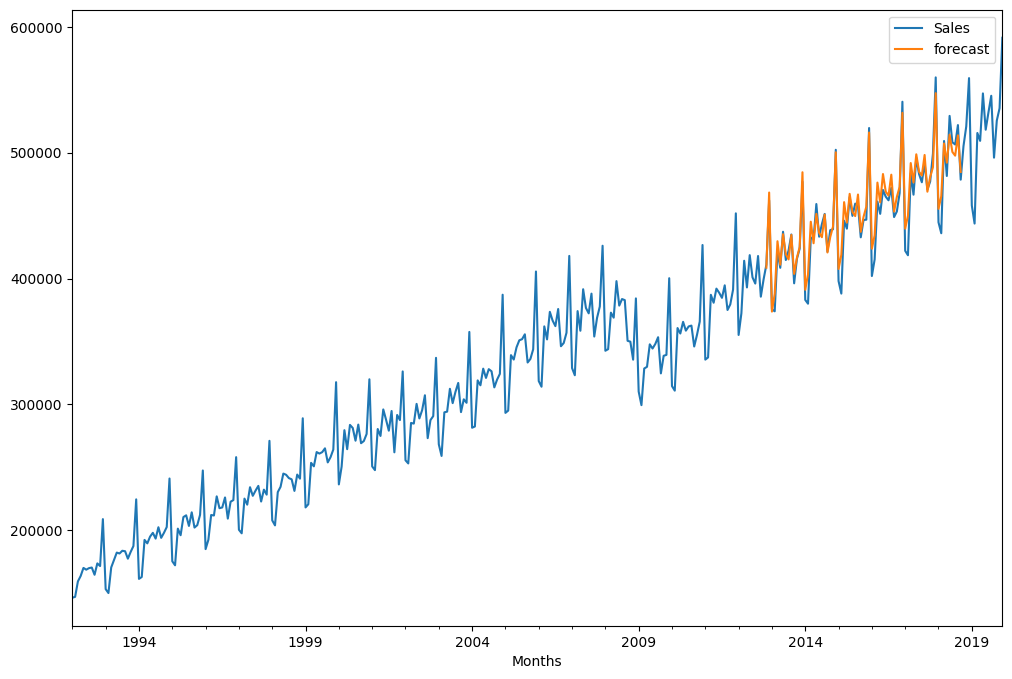

In [233]:
#here start is the starting index from where we want to start the prediction from
df['forecast']=results.predict(start=250,end=320,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

Accuracy check:

In [235]:
tst=df['Sales'].iloc[250:320]
pred=df['forecast'].dropna()
pred.dropna()

In [237]:
import numpy as np

In [238]:
#MAPE (Mean absolute percentage error)
mape = np.mean((pred - tst)/(tst))
mape


0.01098086347551118

since the error is 1% so accuracy is 99%

_____________________________________________________________________________________________________________________

Now doing Predictions

so now to do future pridiction we need to extend the df to few dates ahead with null values which then will be filled with the predicted values

In [239]:
from pandas.tseries.offsets import DateOffset
#creating extra indexes
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]



In [240]:
#creating df using the extra indexes
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df


,Sales,Seasonal diff,forecast
2020-01-01,NaN,NaN,NaN
2020-02-01,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN


In [241]:
# now concatinating that extra df with the original df
future_df=pd.concat([df,future_datest_df])

In [242]:
future_df

,Sales,Seasonal diff,forecast
1992-01-01,146376.0,NaN,NaN
1992-02-01,147079.0,NaN,NaN
1992-03-01,159336.0,NaN,NaN
1992-04-01,163669.0,NaN,NaN
1992-05-01,170068.0,NaN,NaN
...,...,...,...
2021-07-01,NaN,NaN,NaN
2021-08-01,NaN,NaN,NaN
2021-09-01,NaN,NaN,NaN
2021-10-01,NaN,NaN,NaN


<AxesSubplot: >

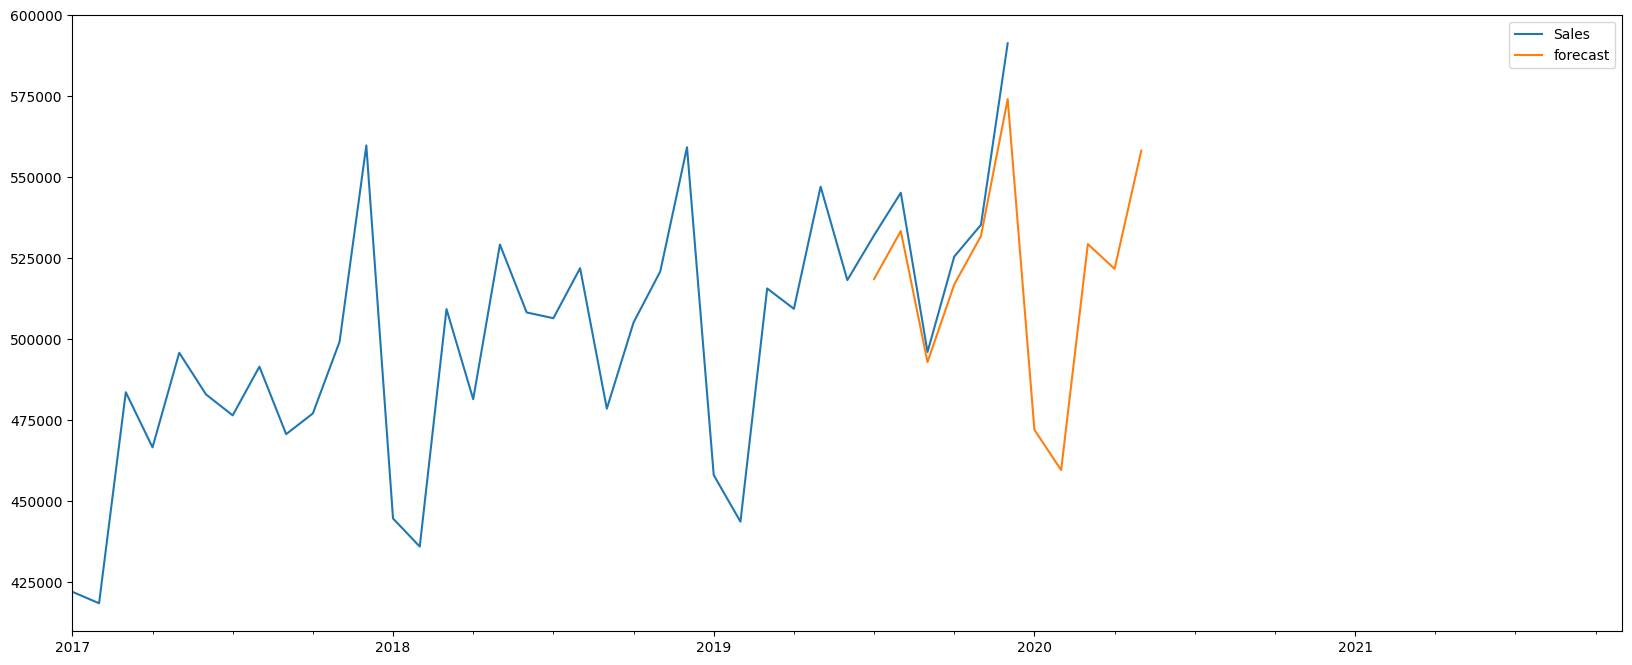

In [243]:
#now doing the future predictions
future_df['forecast'] = results.predict(start=330, end=340,dynamic=True)  
future_df.iloc[300:400][['Sales', 'forecast']].plot(figsize=(20, 8)) 

In [244]:
future_df['forecast'].tail()

2021-07-01   NaN
2021-08-01   NaN
2021-09-01   NaN
2021-10-01   NaN
2021-11-01   NaN
Name: forecast, dtype: float64